In [1]:
#Import all the necessary modules
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import random
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
import copy
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from random import randint

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
project_path = "/content/drive/MyDrive/Data/IHMStefanini_industrial_safety_and_health_database_with_accidents_description.csv"
industrial_safety_df = pd.read_csv(project_path)

In [4]:
import re
import nltk
from nltk.tokenize import word_tokenize
#nltk.download('punkt')
from nltk.corpus import stopwords
#nltk.download('stopwords')
#stopwords.words('english')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import nltk; nltk.download('wordnet'); nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
sns.set(style="darkgrid")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
# industrial_safety_df = pd.read_csv("IHMStefanini_industrial_safety_and_health_database_with_accidents_description.csv")
# industrial_safety_df.head()

FileNotFoundError: ignored

In [6]:
industrial_safety_df.shape

(425, 11)

### Grouping by Accident Level and Potential Accident Level 

In [7]:
group_acc_level = industrial_safety_df.groupby(['Accident Level'])
group_acc_level.first()

,Unnamed: 0,Data,Countries,Local,Industry Sector,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description
Accident Level,,,,,,,,,,
I,0,01-01-2016 00:00,Country_01,Local_01,Mining,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...
II,22,10-02-2016 00:00,Country_01,Local_03,Mining,IV,Male,Third Party,Others,While aligning the right bracket of tower N ° ...
III,16,06-02-2016 00:00,Country_01,Local_04,Mining,IV,Male,Third Party,Others,"At Rp 050 of level 1620, in circumstances wher..."
IV,4,10-01-2016 00:00,Country_01,Local_04,Mining,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...
V,33,20-02-2016 00:00,Country_01,Local_04,Mining,V,Male,Third Party,Others,Approximately 1:40 p.m. in circumstances that ...


In [8]:
group_ptnl_acc_level = industrial_safety_df.groupby(['Potential Accident Level'])
group_ptnl_acc_level.first()

,Unnamed: 0,Data,Countries,Local,Industry Sector,Accident Level,Genre,Employee or Third Party,Critical Risk,Description
Potential Accident Level,,,,,,,,,,
I,3,08-01-2016 00:00,Country_01,Local_04,Mining,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...
II,9,26-01-2016 00:00,Country_01,Local_06,Metals,I,Male,Third Party,Chemical substances,At the moment the forklift operator went to ma...
III,2,06-01-2016 00:00,Country_01,Local_03,Mining,I,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...
IV,0,01-01-2016 00:00,Country_01,Local_01,Mining,I,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...
V,13,02-02-2016 00:00,Country_01,Local_01,Mining,IV,Male,Third Party,Electrical installation,"In moments that the operator of the Jumbo 2, t..."
VI,321,25-01-2017 00:00,Country_01,Local_03,Mining,V,Male,Third Party,remains of choco,During the process of loading drills in the Ca...


### DataSet Analysis- Basic EDA

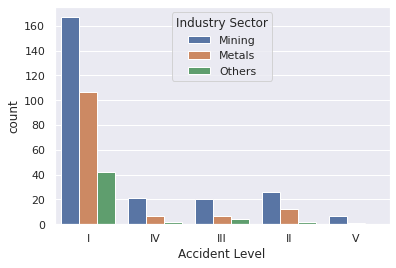

In [9]:
sns.countplot(x ='Accident Level', data = industrial_safety_df, hue ='Industry Sector'); 

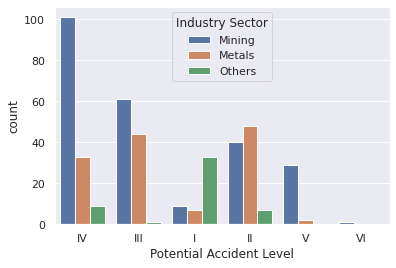

In [10]:
sns.countplot(x ='Potential Accident Level', data = industrial_safety_df, hue ='Industry Sector'); 

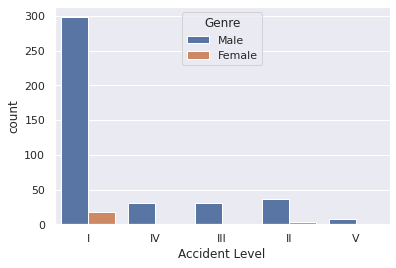

In [11]:
sns.countplot(x ='Accident Level', data = industrial_safety_df, hue ='Genre'); 

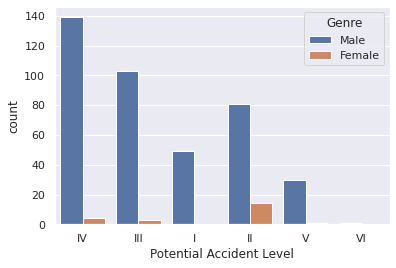

In [12]:
sns.countplot(x ='Potential Accident Level', data = industrial_safety_df, hue ='Genre'); 

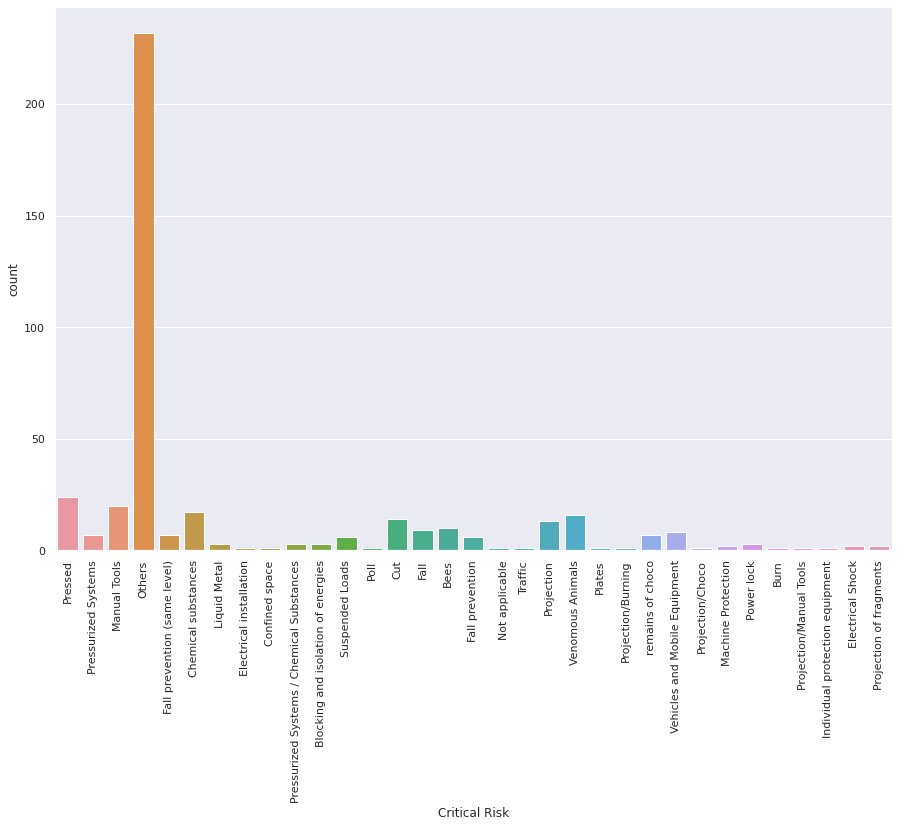

In [13]:
plt.figure(figsize=(15,10))
plt.setp(sns.countplot(industrial_safety_df['Critical Risk']).get_xticklabels(), rotation=90);

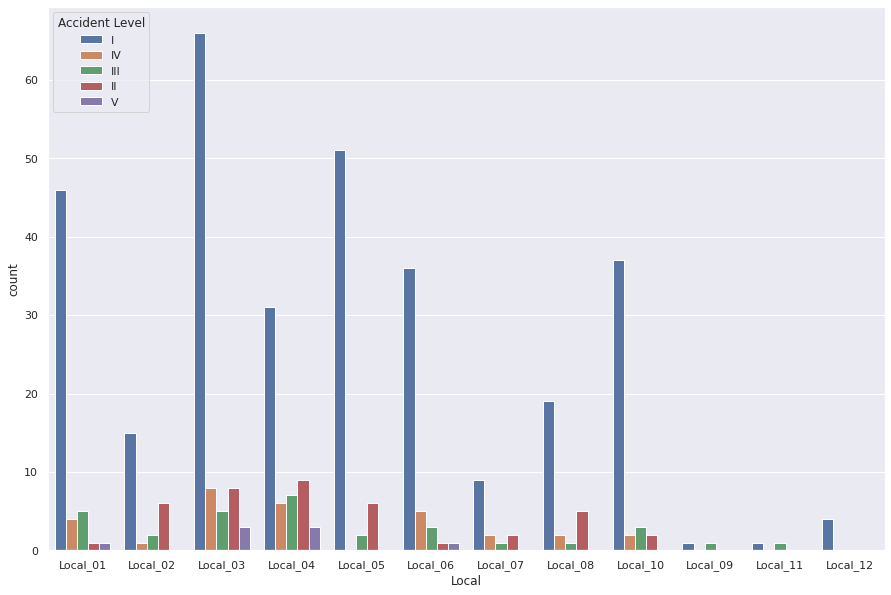

In [14]:
plt.figure(figsize=(15,10))
sns.countplot(industrial_safety_df['Local'], hue = industrial_safety_df['Accident Level']);

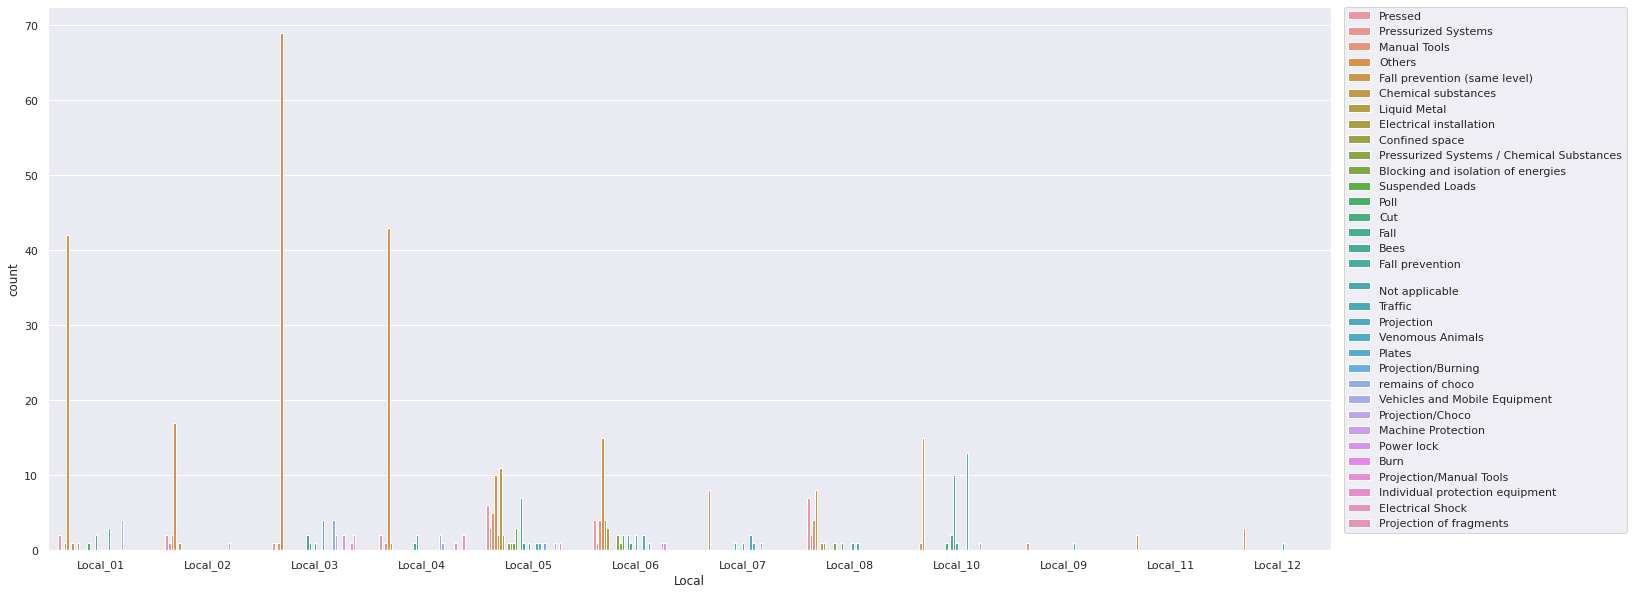

In [15]:
sns.set(rc={'figure.figsize':(23,10)})
sns.countplot(industrial_safety_df['Local'], hue = industrial_safety_df['Critical Risk'])
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
#local_03 has the highesh level of other critical risk

 - #### Labeling The Dataset
 > As per the dataset there are 1-6 level of Accident Level, here we have labeled 1-2 as low risk, 3-4 moderate risk and 5-6 critical risk 

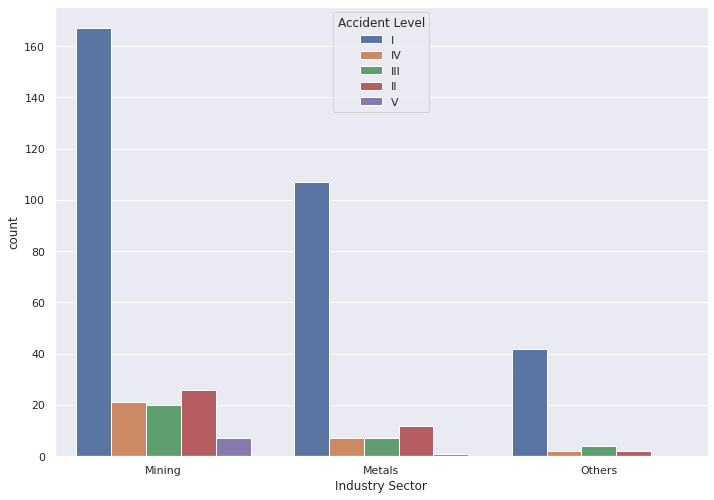

In [16]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(industrial_safety_df['Industry Sector'], hue = industrial_safety_df['Accident Level'])
#Mining sector has the highest number of level 1 accidents
#Mining sector has the higest number of level v accidents

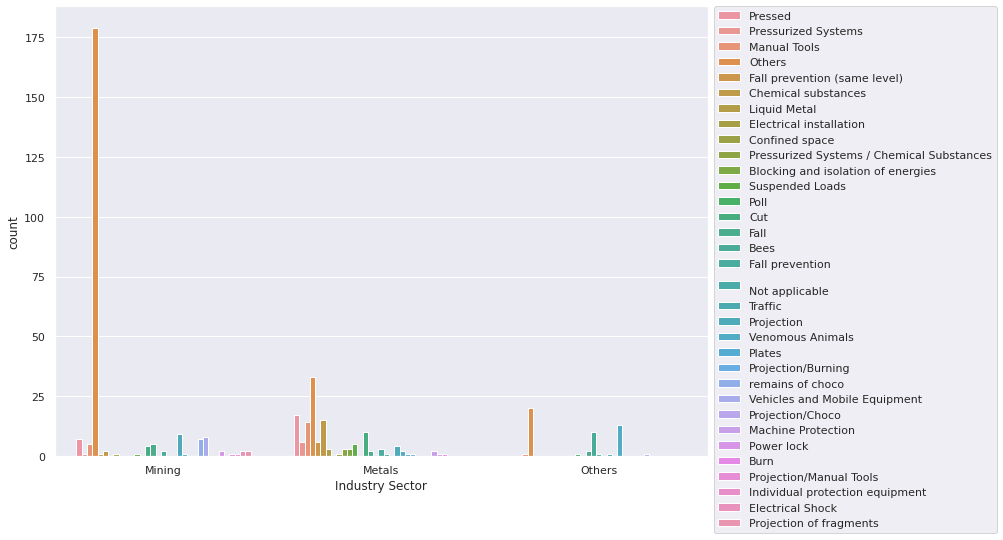

In [17]:
sns.countplot(industrial_safety_df['Industry Sector'], hue = industrial_safety_df['Critical Risk'])
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
# Mining sector has the highest number of critical risk others

In [18]:
industrial_safety_df.groupby(['Industry Sector', 'Critical Risk'])['Industry Sector'].count().sort_values().groupby(level=0).tail(3)

Industry Sector  Critical Risk                
Mining           Vehicles and Mobile Equipment      8
                 Projection                         9
Others           Bees                              10
                 Venomous Animals                  13
Metals           Chemical substances               15
                 Pressed                           17
Others           Others                            20
Metals           Others                            33
Mining           Others                           179
Name: Industry Sector, dtype: int64

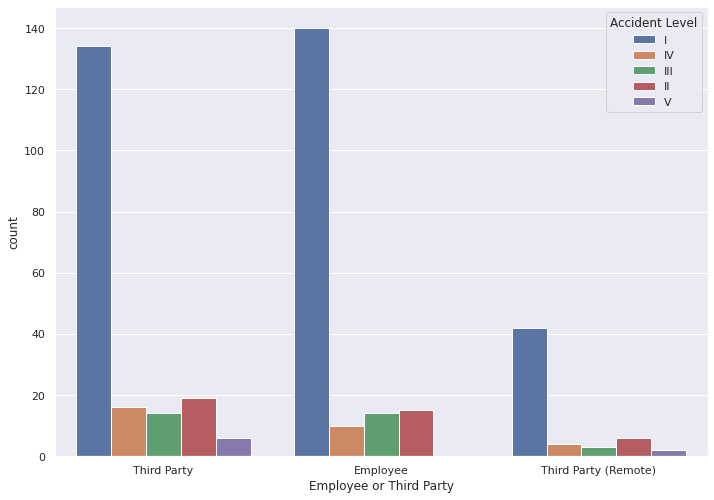

In [19]:
sns.countplot(industrial_safety_df['Employee or Third Party'], hue = industrial_safety_df['Accident Level'])
# Accident level v has been caused mainly by third party and third party remote
# we cannot ascertain about level 1 accidents as they may have been caused by Third party or employee

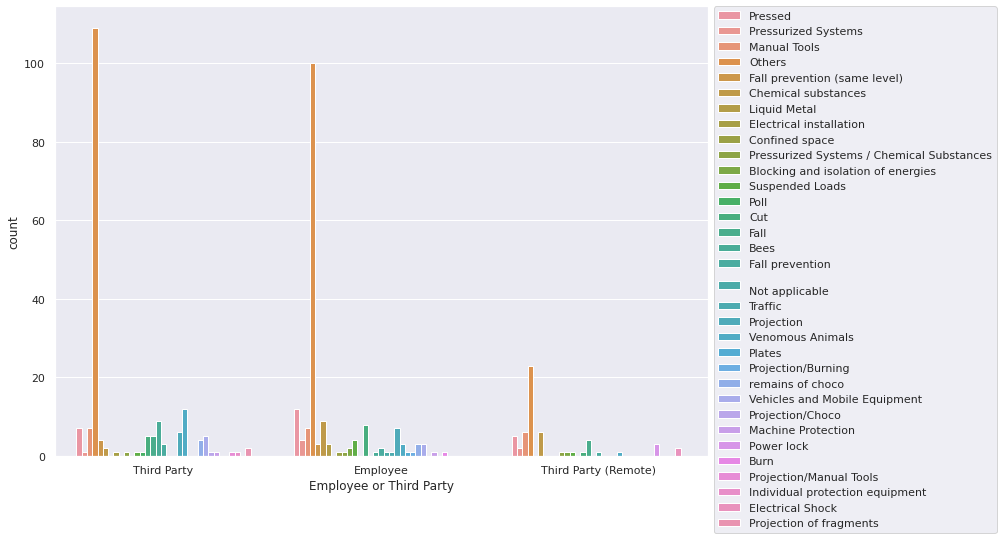

In [20]:
sns.countplot(industrial_safety_df['Employee or Third Party'], hue = industrial_safety_df['Critical Risk'])
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

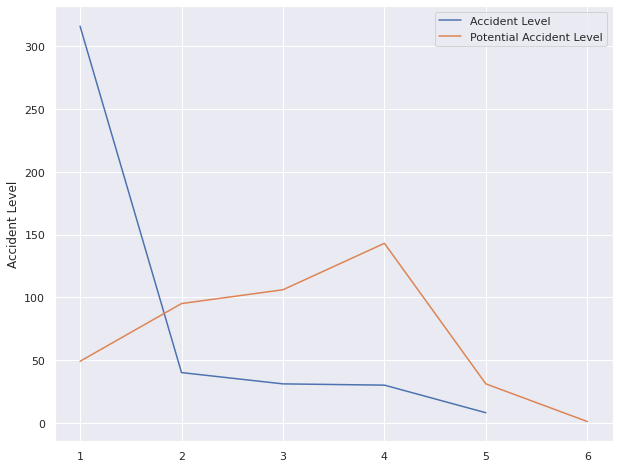

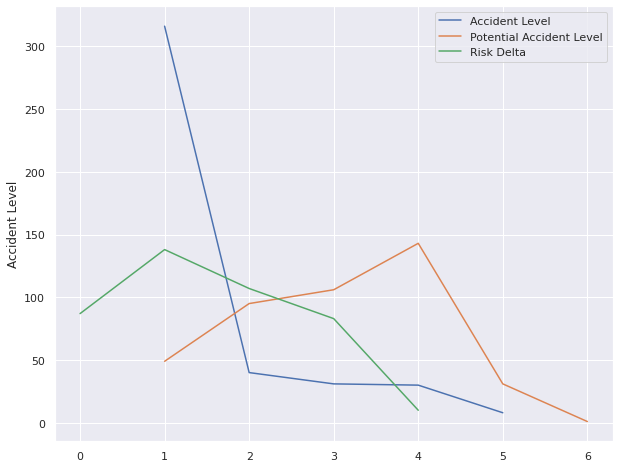

In [21]:
level_map = {'I': 1, 'II': 2,'III': 3 , 'IV' : 4, 'V': 5, 'VI' : 6}
industrial_safety_df['Accident Level'] = pd.Series([level_map[x] for x in industrial_safety_df['Accident Level']], index=industrial_safety_df.index)
industrial_safety_df['Potential Accident Level'] = pd.Series([level_map[x] for x in industrial_safety_df['Potential Accident Level']], index=industrial_safety_df.index)
industrial_safety_df['Risk_differnce'] = industrial_safety_df['Potential Accident Level'] - industrial_safety_df['Accident Level']

acc_level = industrial_safety_df['Accident Level'].value_counts()

risk_delta = industrial_safety_df['Risk_differnce'].value_counts()

potential_acc_level = industrial_safety_df['Potential Accident Level'].value_counts()



## The first plot below shows the distribution of incidents
## The blue line represents the Severity of the accident
## the yellow line represents the potential severity
## The second plot we added a line to indicate the difference in risk 


plt.figure(figsize=(10,8))
sns.lineplot(y=acc_level, x=acc_level.index)
sns.lineplot(y=potential_acc_level, x=potential_acc_level.index)
plt.legend(labels=['Accident Level', 'Potential Accident Level'])


plt.figure(figsize=(10,8))
sns.lineplot(y=acc_level, x=acc_level.index)
sns.lineplot(y=potential_acc_level, x=potential_acc_level.index)
sns.lineplot(y=risk_delta, x=risk_delta.index)
plt.legend(labels=['Accident Level', 'Potential Accident Level', 'Risk Delta'])



In [22]:

industrial_safety_df['Date'] = pd.to_datetime(industrial_safety_df['Date'])
f, axes = plt.subplots(1,1,figsize=(15,5))
sns.lineplot(data = industrial_safety_df['Date'].value_counts())

#Regular Spikes can be seen

KeyError: ignored

In [ ]:
def create_label(accident_level):
    level = str(accident_level)
    if level.__eq__("I") or level.__eq__("II"):
        return "low"
    if level.__eq__("III"):
        return "moderate"
    if level.__eq__("IV") or level.__eq__("V"):
        return "high"
    if level.__eq__("VI"):
        return "critical"
    
industrial_safety_df['Accident Severity'] = industrial_safety_df['Accident Level'].apply(create_label)
industrial_safety_df[['Accident Level','Accident Severity']]

#### We can see that the Mining Sector is the most risky as the most number of accidents recorded in that sector followed by Metals

### Data Cleansing
 

In [23]:
#Renaming Data -> date, Genre -> Gender
#Removing the Column Unnamed as it's just sequence

industrial_safety_df.rename(columns = {'Data': 'Date', 'Genre': 'Gender'}, inplace = True)
industrial_safety_df = industrial_safety_df.drop("Unnamed: 0",axis=1)
industrial_safety_df.head()


,Date,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Gender,Employee or Third Party,Critical Risk,Description,Risk_differnce
0,01-01-2016 00:00,Country_01,Local_01,Mining,1,4,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...,3
1,02-01-2016 00:00,Country_02,Local_02,Mining,1,4,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...,3
2,06-01-2016 00:00,Country_01,Local_03,Mining,1,3,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...,2
3,08-01-2016 00:00,Country_01,Local_04,Mining,1,1,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...,0
4,10-01-2016 00:00,Country_01,Local_04,Mining,4,4,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...,0


In [24]:
industrial_safety_df.describe()

,Accident Level,Potential Accident Level,Risk_differnce
count,425.000000,425.000000,425.000000
mean,1.527059,3.035294,1.508235
std,1.023243,1.155861,1.092665
min,1.000000,1.000000,0.000000
25%,1.000000,2.000000,1.000000
50%,1.000000,3.000000,1.000000
75%,2.000000,4.000000,2.000000
max,5.000000,6.000000,4.000000


In [25]:
industrial_safety_df.isnull().sum()

Date                        0
Countries                   0
Local                       0
Industry Sector             0
Accident Level              0
Potential Accident Level    0
Gender                      0
Employee or Third Party     0
Critical Risk               0
Description                 0
Risk_differnce              0
dtype: int64

In [26]:
industrial_safety_df.dtypes

Date                        object
Countries                   object
Local                       object
Industry Sector             object
Accident Level               int64
Potential Accident Level     int64
Gender                      object
Employee or Third Party     object
Critical Risk               object
Description                 object
Risk_differnce               int64
dtype: object

### Pre-Processing the Text 

- #### Removing all irrelevant characters (Numbers and Punctuation)

In [27]:
def remove_alpha_numerics(description_txt):
    return re.sub('[^a-zA-Z]',' ',description_txt)
industrial_safety_df['Updated Description'] = industrial_safety_df['Description'].apply(remove_alpha_numerics)
industrial_safety_df['Updated Description']

0      While removing the drill rod of the Jumbo    f...
1      During the activation of a sodium sulphide pum...
2      In the sub station MILPO located at level     ...
3      Being      am  approximately in the Nv       C...
4      Approximately at       a m  in circumstances t...
                             ...                        
420    Being approximately      a m  approximately  w...
421    The collaborator moved from the infrastructure...
422    During the environmental monitoring activity i...
423    The Employee performed the activity of strippi...
424    At       a m   when the assistant cleaned the ...
Name: Updated Description, Length: 425, dtype: object

- #### Convert all characters into lowercase

In [28]:
def to_lower_case(description_txt):
    return str(description_txt).lower()
industrial_safety_df['Updated Description'] = industrial_safety_df['Updated Description'].apply(to_lower_case)
industrial_safety_df['Updated Description']

0      while removing the drill rod of the jumbo    f...
1      during the activation of a sodium sulphide pum...
2      in the sub station milpo located at level     ...
3      being      am  approximately in the nv       c...
4      approximately at       a m  in circumstances t...
                             ...                        
420    being approximately      a m  approximately  w...
421    the collaborator moved from the infrastructure...
422    during the environmental monitoring activity i...
423    the employee performed the activity of strippi...
424    at       a m   when the assistant cleaned the ...
Name: Updated Description, Length: 425, dtype: object

- #### Tokenization 

In [29]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [30]:
industrial_safety_df['Updated Description'] = industrial_safety_df.apply(lambda word: nltk.word_tokenize(word['Updated Description']), axis=1)
industrial_safety_df['Updated Description']

0      [while, removing, the, drill, rod, of, the, ju...
1      [during, the, activation, of, a, sodium, sulph...
2      [in, the, sub, station, milpo, located, at, le...
3      [being, am, approximately, in, the, nv, cx, ob...
4      [approximately, at, a, m, in, circumstances, t...
                             ...                        
420    [being, approximately, a, m, approximately, wh...
421    [the, collaborator, moved, from, the, infrastr...
422    [during, the, environmental, monitoring, activ...
423    [the, employee, performed, the, activity, of, ...
424    [at, a, m, when, the, assistant, cleaned, the,...
Name: Updated Description, Length: 425, dtype: object

- #### Removing Stopwords

In [31]:
stop_words = set(stopwords.words('english'))
def remove_stopwords(word):
    return [token for token in word if not token in stop_words]
    
industrial_safety_df['Updated Description'] = industrial_safety_df['Updated Description'].apply(remove_stopwords)
industrial_safety_df['Updated Description']

0      [removing, drill, rod, jumbo, maintenance, sup...
1      [activation, sodium, sulphide, pump, piping, u...
2      [sub, station, milpo, located, level, collabor...
3      [approximately, nv, cx, ob, personnel, begins,...
4      [approximately, circumstances, mechanics, anth...
                             ...                        
420    [approximately, approximately, lifting, kelly,...
421    [collaborator, moved, infrastructure, office, ...
422    [environmental, monitoring, activity, area, em...
423    [employee, performed, activity, stripping, cat...
424    [assistant, cleaned, floor, module, e, central...
Name: Updated Description, Length: 425, dtype: object

- #### Stemming

In [32]:
stemmer = PorterStemmer()
def stem_tokens(tokens):
    return [stemmer.stem(index) for index in tokens]
industrial_safety_df['Updated Description Stems'] = industrial_safety_df['Updated Description'].apply(stem_tokens)
industrial_safety_df['Updated Description Stems']

0      [remov, drill, rod, jumbo, mainten, supervisor...
1      [activ, sodium, sulphid, pump, pipe, uncoupl, ...
2      [sub, station, milpo, locat, level, collabor, ...
3      [approxim, nv, cx, ob, personnel, begin, task,...
4      [approxim, circumst, mechan, anthoni, group, l...
                             ...                        
420    [approxim, approxim, lift, kelli, hq, toward, ...
421    [collabor, move, infrastructur, offic, julio, ...
422    [environment, monitor, activ, area, employe, s...
423    [employe, perform, activ, strip, cathod, pull,...
424    [assist, clean, floor, modul, e, central, camp...
Name: Updated Description Stems, Length: 425, dtype: object

#### As we can see due to stemming changed some of the words incorrectly, so we will do Lemmatization and compare

- #### Lemmatization

In [33]:
#nltk.download('wordnet')
lemma = WordNetLemmatizer()
def lematize_tokens(tokens):
    return [lemma.lemmatize(word=w,pos='v') for w in tokens]
industrial_safety_df['Updated Description Lemmas'] = industrial_safety_df['Updated Description'].apply(lematize_tokens)
industrial_safety_df['Updated Description Lemmas']

0      [remove, drill, rod, jumbo, maintenance, super...
1      [activation, sodium, sulphide, pump, pip, unco...
2      [sub, station, milpo, locate, level, collabora...
3      [approximately, nv, cx, ob, personnel, begin, ...
4      [approximately, circumstances, mechanics, anth...
                             ...                        
420    [approximately, approximately, lift, kelly, hq...
421    [collaborator, move, infrastructure, office, j...
422    [environmental, monitor, activity, area, emplo...
423    [employee, perform, activity, strip, cathodes,...
424    [assistant, clean, floor, module, e, central, ...
Name: Updated Description Lemmas, Length: 425, dtype: object

- #### As we can see Lemmatization performed much better than the stemming so we will preffer lemmatization here 

#### Remove the words having length <= 2

In [34]:
# still few nonsense words exist in the lemmatized tokens
# we are going to remove those as they can be noise to the data
def remove_noise(tokens):
    return [i for i in tokens if len(i) > 2]
industrial_safety_df['Updated Description Lemmas'] = industrial_safety_df['Updated Description Lemmas'].apply(remove_noise)
industrial_safety_df['Updated Description Lemmas']

0      [remove, drill, rod, jumbo, maintenance, super...
1      [activation, sodium, sulphide, pump, pip, unco...
2      [sub, station, milpo, locate, level, collabora...
3      [approximately, personnel, begin, task, unlock...
4      [approximately, circumstances, mechanics, anth...
                             ...                        
420    [approximately, approximately, lift, kelly, to...
421    [collaborator, move, infrastructure, office, j...
422    [environmental, monitor, activity, area, emplo...
423    [employee, perform, activity, strip, cathodes,...
424    [assistant, clean, floor, module, central, cam...
Name: Updated Description Lemmas, Length: 425, dtype: object

- So this is the required corpus after text preprocessing. 
- now we will convert back this list to string for encoding the text.

### Final Text Data After Preprocessing

In [35]:
#Convert the list of tokens into back to the string
def to_string(tokens):
    return ' '.join(tokens)
industrial_safety_df['Updated Description'] = industrial_safety_df['Updated Description Lemmas'].apply(to_string)
industrial_safety_df['Updated Description']

0      remove drill rod jumbo maintenance supervisor ...
1      activation sodium sulphide pump pip uncouple s...
2      sub station milpo locate level collaborator ex...
3      approximately personnel begin task unlock soqu...
4      approximately circumstances mechanics anthony ...
                             ...                        
420    approximately approximately lift kelly towards...
421    collaborator move infrastructure office julio ...
422    environmental monitor activity area employee s...
423    employee perform activity strip cathodes pull ...
424    assistant clean floor module central camp slip...
Name: Updated Description, Length: 425, dtype: object

In [36]:
industrial_safety_df.head()

,Date,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Gender,Employee or Third Party,Critical Risk,Description,Risk_differnce,Updated Description,Updated Description Stems,Updated Description Lemmas
0,01-01-2016 00:00,Country_01,Local_01,Mining,1,4,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...,3,remove drill rod jumbo maintenance supervisor ...,"[remov, drill, rod, jumbo, mainten, supervisor...","[remove, drill, rod, jumbo, maintenance, super..."
1,02-01-2016 00:00,Country_02,Local_02,Mining,1,4,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...,3,activation sodium sulphide pump pip uncouple s...,"[activ, sodium, sulphid, pump, pipe, uncoupl, ...","[activation, sodium, sulphide, pump, pip, unco..."
2,06-01-2016 00:00,Country_01,Local_03,Mining,1,3,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...,2,sub station milpo locate level collaborator ex...,"[sub, station, milpo, locat, level, collabor, ...","[sub, station, milpo, locate, level, collabora..."
3,08-01-2016 00:00,Country_01,Local_04,Mining,1,1,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...,0,approximately personnel begin task unlock soqu...,"[approxim, nv, cx, ob, personnel, begin, task,...","[approximately, personnel, begin, task, unlock..."
4,10-01-2016 00:00,Country_01,Local_04,Mining,4,4,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...,0,approximately circumstances mechanics anthony ...,"[approxim, circumst, mechan, anthoni, group, l...","[approximately, circumstances, mechanics, anth..."


### Text Visualization
> Here we will try to visualize each token of the description

In [37]:
#splitting the dataset
#we will fecth the description tokens 
texts_in_severity_low = industrial_safety_df[industrial_safety_df['Accident Severity'] == "low"]['Updated Description'] 
texts_in_severity_moderate = industrial_safety_df[industrial_safety_df['Accident Severity'] == "moderate"]['Updated Description'] 
texts_in_severity_high = industrial_safety_df[industrial_safety_df['Accident Severity'] == "high"]['Updated Description'] 
texts_in_severity_critical = industrial_safety_df[industrial_safety_df['Accident Severity'] == "critical"]['Updated Description'] 


KeyError: ignored

- Let’s visualize our corpus corresponding to the labels 
- Taking top 15 words and see their frequency in the corpus

In [ ]:
from yellowbrick.text import FreqDistVisualizer
def show_text_freq(item):
    if(len(item) > 0):
        vectorizer = CountVectorizer()
        docs       = vectorizer.fit_transform(item)
        features   = vectorizer.get_feature_names()
        visualizer = FreqDistVisualizer(features=features, n=15, color='rgb', orient='V')
        visualizer.fit(docs)
        visualizer.show()
    else :
        print("Empty data-set")

In [ ]:
show_text_freq(texts_in_severity_low)

In [ ]:
show_text_freq(texts_in_severity_moderate)

In [ ]:
show_text_freq(texts_in_severity_high)

In [ ]:
show_text_freq(texts_in_severity_critical)

In [ ]:
industrial_safety_df.head()

> ## Data Encoding

> - ### Bag of Words

In [38]:
#creating the document or corpus
corpus_accident_description = industrial_safety_df['Description'].values
#corpus_accident_description

In [39]:
vec_bow = CountVectorizer()
X = vec_bow.fit_transform(corpus_accident_description)
features = vec_bow.get_feature_names()
#print(features)
print(X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]


> - ### TF-IDF Encoding

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec_tfidf = TfidfVectorizer()
X = vec_tfidf.fit_transform(corpus_accident_description)
features = vec_tfidf.get_feature_names()
#print(features)
print(X.toarray())

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.19617859 0.         0.         ... 0.         0.         0.        ]]


 - ### Random Forest Classifier

In [45]:
appos = {"ain't": "am not", "aren't": "are not", "can't": "cannot", 
         "can't've": "cannot have", "'cause": "because", 
         "could've": "could have", "couldn't": "could not", 
         "couldn't've": "could not have", "didn't": "did not", 
         "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
         "hadn't've": "had not have", "hasn't": "has not", 
         "haven't": "have not", "he'd": "he would", "he'd've": "he would have", 
         "he'll": "he will", "he'll've": "he will have", 
         "he's": "he is", "how'd": "how did", 
         "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
         "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
         "I'll've": "I will have", "I'm": "I am", "I've": "I have", 
         "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
         "it'll": "it will", "it'll've": "it will have", "it's": "it is", 
         "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
         "might've": "might have", "mightn't": "might not", 
         "mightn't've": "might not have", "must've": "must have", 
         "mustn't": "must not", "mustn't've": "must not have", 
         "needn't": "need not", "needn't've": "need not have",
         "o'clock": "of the clock", "oughtn't": "ought not", 
         "oughtn't've": "ought not have", "shan't": "shall not", 
         "sha'n't": "shall not", "shan't've": "shall not have", 
         "she'd": "she would", "she'd've": "she would have", 
         "she'll": "she will", "she'll've": "she will have",
         "she's": "she is", "should've": "should have", 
         "shouldn't": "should not", "shouldn't've": "should not have", 
         "so've": "so have", "so's": "so is", 
         "that'd": "that had", "that'd've": "that would have", 
         "that's": "that that is", "there'd": "there would", 
         "there'd've": "there would have", "there's": "there is", 
         "they'd": "they would", "they'd've": "they would have", 
         "they'll": "they will", "they'll've": "they will have", 
         "they're": "they are", "they've": "they have", 
         "to've": "to have", "wasn't": "was not", "we'd": "we would", 
         "we'd've": "we would have", "we'll": "we will", 
         "we'll've": "we will have", "we're": "we are", 
         "we've": "we have", "weren't": "were not", 
         "what'll": "what will", "what'll've": "what will have", 
         "what're": "what are", "what's": "what is", 
         "what've": "what have", "when's": "when is", 
         "when've": "when have", "where'd": "where did", 
         "where's": "where is", "where've": "where have", 
         "who'll": "who will", "who'll've": "who will have", 
         "who's": "who is", "who've": "who have", 
         "why's": "why is", "why've": "why have", "will've": "will have", 
         "won't": "will not", "won't've": "will not have",
         "would've": "would have", "wouldn't": "would not", 
         "wouldn't've": "would not have", "y'all": "you all", 
         "y'all'd": "you all would", "y'all'd've": "you all would have", 
         "y'all're": "you all are", "y'all've": "you all have", 
         "you'd": "you would", "you'd've": "you would have",
         "you'll": "you will", "you'll've": "you will have", 
         "you're": "you are", "you've": "you have"}

# Helper function to replace appos
def replace_words(headline):
    cleaned_headlines = []
    for word in str(headline).split():
        if word.lower() in appos.keys():
            cleaned_headlines.append(appos[word.lower()])
        else:
            cleaned_headlines.append(word)
    return ' '.join(cleaned_headlines)

# Helper function to remove punctuations
# Reference: https://www.programiz.com/python-programming/methods/string/translate
PUNCT_TO_REMOVE = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~' #string.punctuation
def remove_punctuation(text):
    """function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

# Helper function to lemmatize
lemmatizer = WordNetLemmatizer()
def lemmatize(text):
  return ''.join([lemmatizer.lemmatize(word) for word in text])

# Helper function to remove stopwords
stoplist = set(stopwords.words('english'))
stoplist.remove('not')
def remove_stopwords(text):
    """function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in stoplist])

# Helper function for wordcloud
# Reference: https://www.kaggle.com/aashita/word-clouds-of-various-shapes
def plot_wordcloud(text, mask = None, max_words = 500, max_font_size = 40, 
                   figure_size = (12, 6), title = None, title_size = 15):
    wordcloud = WordCloud(background_color = 'white', max_words = max_words,
                          random_state = 42, width = 350, height = 150, 
                          mask = mask, stopwords = stoplist, collocations = False)
    wordcloud.generate(str(text))
    
    plt.figure(figsize = figure_size)
    plt.imshow(wordcloud, interpolation = 'bilinear');
    plt.title(title, fontdict = {'size': title_size, 'color': 'black', 
                               'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()

lemmatizer = WordNetLemmatizer()
def lem(text):
    pos_dict = {'N': wn.NOUN, 'V': wn.VERB, 'J': wn.ADJ, 'R': wn.ADV}
    return(' '.join([lemmatizer.lemmatize(w,pos_dict.get(t, wn.NOUN)) for w,t in nltk.pos_tag(text.split())]))

Word Cloud


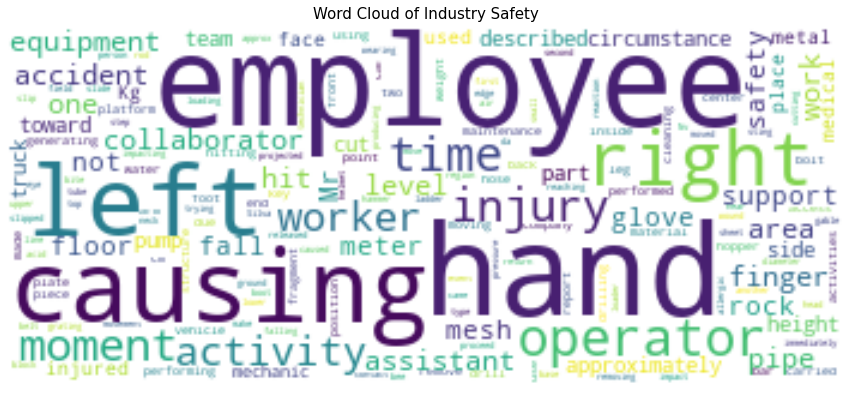

In [46]:
from wordcloud import WordCloud
print('Word Cloud')
print('=='*50)
industrial_safety_df['Description'] = industrial_safety_df['Description'].fillna('')
indStr = ' '.join(industrial_safety_df['Description'])
plot_wordcloud(indStr, title = 'Word Cloud of Industry Safety')

In [47]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [48]:
print('\*'*30); 
print('Converting headlines to lower case')
industrial_safety_df['cleaned_Description'] = industrial_safety_df['Description'].apply(lambda x : x.lower())

print('Replacing apostrophes to the standard lexicons')
industrial_safety_df['cleaned_Description'] = industrial_safety_df['cleaned_Description'].apply(lambda x : replace_words(x))

print('Removing punctuations')
industrial_safety_df['cleaned_Description'] = industrial_safety_df['cleaned_Description'].apply(lambda x: remove_punctuation(x))

print('Applying Lemmatizer')
industrial_safety_df['cleaned_Description'] = industrial_safety_df['cleaned_Description'].apply(lambda x: lem(x))

print('Removing multiple spaces between words')
industrial_safety_df['cleaned_Description'] = industrial_safety_df['cleaned_Description'].apply(lambda x: re.sub(' +', ' ', x))

# print('Removing stopwords')
industrial_safety_df['cleaned_Description'] = industrial_safety_df['cleaned_Description'].apply(lambda x: remove_stopwords(x))
print('\*'*30)
industrial_safety_df.head()

\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*
Converting headlines to lower case
Replacing apostrophes to the standard lexicons
Removing punctuations
Applying Lemmatizer
Removing multiple spaces between words
\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*


,Date,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Gender,Employee or Third Party,Critical Risk,Description,Risk_differnce,Updated Description,Updated Description Stems,Updated Description Lemmas,cleaned_Description
0,01-01-2016 00:00,Country_01,Local_01,Mining,1,4,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...,3,remove drill rod jumbo maintenance supervisor ...,"[remov, drill, rod, jumbo, mainten, supervisor...","[remove, drill, rod, jumbo, maintenance, super...",removing drill rod jumbo 08 maintenance superv...
1,02-01-2016 00:00,Country_02,Local_02,Mining,1,4,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...,3,activation sodium sulphide pump pip uncouple s...,"[activ, sodium, sulphid, pump, pipe, uncoupl, ...","[activation, sodium, sulphide, pump, pip, unco...",activation sodium sulphide pump piping wa unco...
2,06-01-2016 00:00,Country_01,Local_03,Mining,1,3,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...,2,sub station milpo locate level collaborator ex...,"[sub, station, milpo, locat, level, collabor, ...","[sub, station, milpo, locate, level, collabora...",substation milpo located level 170 collaborato...
3,08-01-2016 00:00,Country_01,Local_04,Mining,1,1,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...,0,approximately personnel begin task unlock soqu...,"[approxim, nv, cx, ob, personnel, begin, task,...","[approximately, personnel, begin, task, unlock...",945 approximately nv 1880 cx695 ob7 personnel ...
4,10-01-2016 00:00,Country_01,Local_04,Mining,4,4,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...,0,approximately circumstances mechanics anthony ...,"[approxim, circumst, mechan, anthoni, group, l...","[approximately, circumstances, mechanics, anth...",approximately 1145 circumstance mechanic antho...


## Generating embedding GloVE



In [66]:
max_features = 3213
maxlen = 30
embedding_size = 300

In [50]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=max_features,lower=True)
tokenizer.fit_on_texts(industrial_safety_df['cleaned_Description'])

In [53]:
seq = tokenizer.texts_to_sequences(industrial_safety_df['cleaned_Description'])
padded= pad_sequences(seq,maxlen=maxlen,padding="post")

In [54]:
X=padded

In [55]:
tokenizer.word_index

{'wa': 1,
 'employee': 2,
 'hand': 3,
 'causing': 4,
 'left': 5,
 'right': 6,
 'operator': 7,
 'activity': 8,
 'time': 9,
 'injury': 10,
 'moment': 11,
 'worker': 12,
 'collaborator': 13,
 'area': 14,
 'one': 15,
 'work': 16,
 'equipment': 17,
 'finger': 18,
 'assistant': 19,
 'accident': 20,
 'pipe': 21,
 'level': 22,
 'hit': 23,
 'floor': 24,
 'support': 25,
 'mesh': 26,
 'rock': 27,
 'fall': 28,
 'not': 29,
 'mr': 30,
 'safety': 31,
 'glove': 32,
 'meter': 33,
 'team': 34,
 'approximately': 35,
 'height': 36,
 'part': 37,
 'side': 38,
 'described': 39,
 'circumstance': 40,
 'pump': 41,
 'truck': 42,
 'face': 43,
 'cut': 44,
 'metal': 45,
 'used': 46,
 'kg': 47,
 'injured': 48,
 'place': 49,
 'towards': 50,
 'medical': 51,
 'performing': 52,
 'mechanic': 53,
 'two': 54,
 'using': 55,
 'point': 56,
 'foot': 57,
 'platform': 58,
 'made': 59,
 'cm': 60,
 'remove': 61,
 'end': 62,
 'performed': 63,
 'generating': 64,
 'access': 65,
 'maintenance': 66,
 'fragment': 67,
 'inside': 68,
 '2'

In [57]:
num_words = len(tokenizer.word_index) + 1
print(num_words)

3213


In [58]:
import numpy as np
EMBEDDING_FILE = '/content/drive/MyDrive/Data/glove.6B.300d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((num_words, 300))

for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [59]:
embedding_matrix.shape

(3213, 300)

In [63]:
embedding_matrix[1]


array([ 0.13053   , -0.11906   , -0.43076   ,  0.52701002, -0.43518001,
       -0.091907  , -0.31525999,  0.23774   , -0.095145  , -0.14505   ,
        0.15854   , -0.23717   , -0.35506001,  0.099615  ,  0.38429001,
       -0.072857  , -0.45506001,  0.65009999,  0.062081  ,  0.0017903 ,
       -0.54110003, -0.11608   ,  0.24789999,  0.31707001, -0.062319  ,
        0.022712  ,  0.13663   , -0.45543   ,  0.46752   , -0.52217001,
        0.62923998, -0.45091   ,  0.70539999,  0.63935   ,  0.39219999,
       -0.035215  ,  0.038173  , -0.039306  , -0.49895   , -0.27175   ,
        0.025864  , -0.83450001, -0.14706001,  0.11938   ,  0.029906  ,
       -0.20898999, -0.38993001, -0.11933   , -0.25595   , -0.68156999,
       -0.21164   , -0.026537  ,  0.3457    ,  0.016647  , -0.50885999,
        0.031879  ,  0.22402   ,  0.17292   ,  0.015874  , -0.61616999,
        0.14723   ,  0.30394   , -0.42519999,  0.042489  ,  0.6541    ,
       -0.41012001, -0.11586   , -0.18581   ,  0.28195   ,  0.67

In [64]:
X

array([[ 686,   25,  834, ...,   97,  329,  327],
       [1111, 1112,   41, ..., 1658, 1659, 1660],
       [1114,  192,   22, ...,   13,    4,   10],
       ...,
       [3205, 1487,    8, ...,    0,    0,    0],
       [   2,   63,    8, ...,    0,    0,    0],
       [1068,   19,  617, ...,    0,    0,    0]], dtype=int32)

## Accident Level as target

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# vec_tfidf = TfidfVectorizer()
# X = vec_tfidf.fit_transform(corpus_accident_description)
# features = vec_tfidf.get_feature_names()
# #print(features)
# print(X.toarray())

In [52]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout

In [ ]:
### Vocabulary size
voc_size=5000

In [ ]:
# corpus_accident_description = industrial_safety_df['cleaned_Description'].values

In [ ]:
# onehot_repr=[one_hot(words,voc_size)for words in corpus_accident_description] 
# onehot_repr

In [ ]:
# sent_length=30
# embedded_docs=pad_sequences(onehot_repr,padding='post',maxlen=sent_length)
# print(embedded_docs)

In [ ]:
# embedded_docs[5]

In [143]:
#glove and glove100 and 300,multilayer bidirectional ///
embedding_vector_features=100
model=Sequential()
model.add(Embedding(max_features, embedding_size,input_length = maxlen,weights = [embedding_matrix]))
# model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
# model.add(Bidirectional(LSTM(100,return_sequences=True)))
model.add(Bidirectional(LSTM(100)))
# model.add(Dense(10, activation='relu'))
model.add(Dense(5, activation='softmax'))
# model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 30, 300)           963900    
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 200)               320800    
_________________________________________________________________
dense_21 (Dense)             (None, 5)                 1005      
Total params: 1,285,705
Trainable params: 1,285,705
Non-trainable params: 0
_________________________________________________________________
None


In [149]:

model1 = Sequential()
model1.add(Embedding(max_features, 300, input_length=maxlen,weights = [embedding_matrix]))
# model1.add(LSTM(units=100, dropout=0.2, recurrent_dropout=0.2))
# model1.add(LSTM(units=100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
# model1.add(Bidirectional(LSTM(150,return_sequences=True)))
model1.add(LSTM(units=100, recurrent_dropout=0.2))
# model1.add(Dropout(0.2))
model1.add(Dense(50, activation='relu'))
model1.add(Dense(5, activation='softmax'))
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model1.summary())

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 30, 300)           963900    
_________________________________________________________________
lstm_36 (LSTM)               (None, 100)               160400    
_________________________________________________________________
dense_24 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_25 (Dense)             (None, 5)                 255       
Total params: 1,129,605
Trainable params: 1,129,605
Non-trainable params: 0
_________________________________________________________________
None


In [68]:
y_acc=industrial_safety_df['Accident Level']

In [69]:
y_acc

0      1
1      1
2      1
3      1
4      4
      ..
420    1
421    1
422    1
423    1
424    1
Name: Accident Level, Length: 425, dtype: int64

In [70]:
from sklearn.preprocessing import LabelEncoder

In [111]:
encoder = LabelEncoder()
encoder.fit(y_acc)
encoded_Y= encoder.transform(y_acc)

In [112]:
encoded_Y.shape

(425,)

In [73]:
encoded_Y

array([0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 1, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0,
       0, 3, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 1, 3, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 3, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       3, 3, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 3, 0, 2, 2, 3, 2, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 3, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 2, 3, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 0, 2, 0, 1, 2, 3, 0, 0,
       1, 0, 2, 0, 0, 3, 3, 0, 0, 3, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 3, 2, 0,
       0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 2, 3,

In [109]:
from keras.utils import np_utils
dummy_y= np_utils.to_categorical(encoded_Y)

In [110]:
dummy_y.shape

(425, 5)

In [76]:
import numpy as np
X_acc=np.array(X)


In [77]:
dummy_y[0]

array([1., 0., 0., 0., 0.], dtype=float32)

In [78]:
X_acc[0]

array([ 686,   25,  834, 1648, 1649,  191, 1110,   53,   25,   15,   62,
         72,   17,  328,    3,   97, 1650,  191,   11,   97,  108,   56,
         25, 1651,   18,   53,   91,   97,  329,  327], dtype=int32)

In [79]:
X_acc.shape,encoded_Y.shape

((425, 30), (425,))

In [126]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_acc, dummy_y, test_size=0.33, random_state=42,shuffle=True)

In [145]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=150,batch_size=30)

Epoch 1/150
10/10 [==============================] - 5s 210ms/step - loss: 1.3213 - accuracy: 0.5839 - val_loss: 0.8481 - val_accuracy: 0.7801
Epoch 2/150
10/10 [==============================] - 1s 112ms/step - loss: 0.9454 - accuracy: 0.7046 - val_loss: 0.8784 - val_accuracy: 0.7801
Epoch 3/150
10/10 [==============================] - 1s 110ms/step - loss: 0.7103 - accuracy: 0.7605 - val_loss: 0.8452 - val_accuracy: 0.7801
Epoch 4/150
10/10 [==============================] - 1s 113ms/step - loss: 0.5909 - accuracy: 0.7779 - val_loss: 0.8608 - val_accuracy: 0.7660
Epoch 5/150
10/10 [==============================] - 1s 109ms/step - loss: 0.5254 - accuracy: 0.8415 - val_loss: 0.8314 - val_accuracy: 0.7589
Epoch 6/150
10/10 [==============================] - 1s 113ms/step - loss: 0.3313 - accuracy: 0.8980 - val_loss: 0.8943 - val_accuracy: 0.6950
Epoch 7/150
10/10 [==============================] - 1s 110ms/step - loss: 0.2548 - accuracy: 0.9517 - val_loss: 0.8786 - val_accuracy: 0.7376

In [150]:
model1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=150,batch_size=30)

Epoch 1/150
10/10 [==============================] - 4s 155ms/step - loss: 1.5009 - accuracy: 0.5140 - val_loss: 0.9447 - val_accuracy: 0.7801
Epoch 2/150
10/10 [==============================] - 1s 108ms/step - loss: 1.0222 - accuracy: 0.7169 - val_loss: 0.8140 - val_accuracy: 0.7801
Epoch 3/150
10/10 [==============================] - 1s 111ms/step - loss: 0.9466 - accuracy: 0.7049 - val_loss: 0.8203 - val_accuracy: 0.7801
Epoch 4/150
10/10 [==============================] - 1s 107ms/step - loss: 0.8465 - accuracy: 0.7112 - val_loss: 0.8270 - val_accuracy: 0.7801
Epoch 5/150
10/10 [==============================] - 1s 107ms/step - loss: 0.7519 - accuracy: 0.7247 - val_loss: 0.8148 - val_accuracy: 0.7730
Epoch 6/150
10/10 [==============================] - 1s 108ms/step - loss: 0.7338 - accuracy: 0.7188 - val_loss: 0.8127 - val_accuracy: 0.7518
Epoch 7/150
10/10 [==============================] - 1s 107ms/step - loss: 0.6165 - accuracy: 0.8032 - val_loss: 0.8121 - val_accuracy: 0.7660

In [96]:
y_pred=model.predict_classes(X_test)


In [100]:
dummy_pred_y=np_utils.to_categorical(encoder.fit_transform(y_pred))

In [101]:
dummy_pred_y

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],


In [ ]:
# y_pred1=model.predict_classes(X_test)

In [103]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 25ms/step - loss: 1.7700 - accuracy: 0.7518


[1.769991397857666, 0.7517730593681335]

In [ ]:
# from sklearn.metrics import confusion_matrix
# confusion_matrix(y_test,y_pred)

In [114]:
y_dummy_pred=np_utils.to_categorical(encoder.fit_transform(y_pred))

In [115]:
y_dummy_pred[0]

array([1., 0., 0., 0.], dtype=float32)

In [105]:
y_test[0]

array([1., 0., 0., 0., 0.], dtype=float32)

##Potential Accident Level as target

In [117]:
y_pot=industrial_safety_df['Potential Accident Level']

In [118]:
len(y_pot.unique())

6

In [119]:
encoder = LabelEncoder()
encoder.fit(y_pot)
encoded_Y_pot= encoder.transform(y_pot)
dummy_y_pot= np_utils.to_categorical(encoded_Y_pot)

In [131]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_acc, dummy_y_pot, test_size=0.33, random_state=42,shuffle=True)

In [141]:
embedding_vector_features=100
model2=Sequential()
model2.add(Embedding(max_features, embedding_size,input_length = maxlen,weights = [embedding_matrix]))
# model.add(Bidirectional(LSTM(100,return_sequences=True)))
model2.add(Bidirectional(LSTM(100)))
# model2.add(LSTM(100))
model.add(Dense(10, activation='relu'))
model2.add(Dense(6, activation='softmax'))
# model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model2.summary())

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 30, 300)           963900    
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 200)               320800    
_________________________________________________________________
dense_20 (Dense)             (None, 6)                 1206      
Total params: 1,285,906
Trainable params: 1,285,906
Non-trainable params: 0
_________________________________________________________________
None


In [142]:
model2.fit(X_train2,y_train2,validation_data=(X_test2,y_test2),epochs=150,batch_size=64)

Epoch 1/150
5/5 [==============================] - 5s 413ms/step - loss: 1.7049 - accuracy: 0.2901 - val_loss: 1.5736 - val_accuracy: 0.2908
Epoch 2/150
5/5 [==============================] - 1s 198ms/step - loss: 1.3852 - accuracy: 0.3801 - val_loss: 1.4920 - val_accuracy: 0.3404
Epoch 3/150
5/5 [==============================] - 1s 191ms/step - loss: 1.2428 - accuracy: 0.5340 - val_loss: 1.4187 - val_accuracy: 0.3901
Epoch 4/150
5/5 [==============================] - 1s 188ms/step - loss: 1.1090 - accuracy: 0.6328 - val_loss: 1.4378 - val_accuracy: 0.3972
Epoch 5/150
5/5 [==============================] - 1s 193ms/step - loss: 0.9560 - accuracy: 0.6592 - val_loss: 1.4144 - val_accuracy: 0.3972
Epoch 6/150
5/5 [==============================] - 1s 187ms/step - loss: 0.7843 - accuracy: 0.7450 - val_loss: 1.4562 - val_accuracy: 0.3972
Epoch 7/150
5/5 [==============================] - 1s 190ms/step - loss: 0.6026 - accuracy: 0.8444 - val_loss: 1.5286 - val_accuracy: 0.4255
Epoch 8/150
5

In [148]:
model2.evaluate(X_test2, y_test2)

5/5 [==============================] - 0s 23ms/step - loss: 3.8474 - accuracy: 0.4255


[3.8473780155181885, 0.42553192377090454]

## Critical risk

In [147]:
len(industrial_safety_df['Critical Risk'].unique())


33